In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold  # StratifiedKFold를 임포트
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [43]:
df = pd.read_csv("balanced_data.csv")
df.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [103]:
df['Severity'].value_counts()

Severity
2    204710
0    204710
1    204710
Name: count, dtype: int64

:막대_차트: Severity와 각 변수의 상관계수:
End_Lng              0.214349
End_Lat              0.175776
Start_Lng            0.158619
Start_Lat            0.148615
Distance(mi)         0.146667
Wind_Chill(F)       -0.095048
Crossing            -0.094677
Traffic_Signal      -0.083863
Temperature(F)      -0.070455
Station             -0.051314
Junction             0.048182
Humidity(%)          0.046105
Pressure(in)        -0.040958
End_Time            -0.025247
Amenity             -0.019975
Stop                -0.011843
Wind_Speed(mph)      0.009462
No_Exit             -0.008750
Bump                -0.007223
Traffic_Calming     -0.006830
Railway             -0.006026
Give_Way             0.004915
Visibility(mi)      -0.003526
Precipitation(in)    0.002190
Roundabout           0.000451
Start_Time           0.000105
Turning_Loop              NaN
Name: Severity, dtype: float64


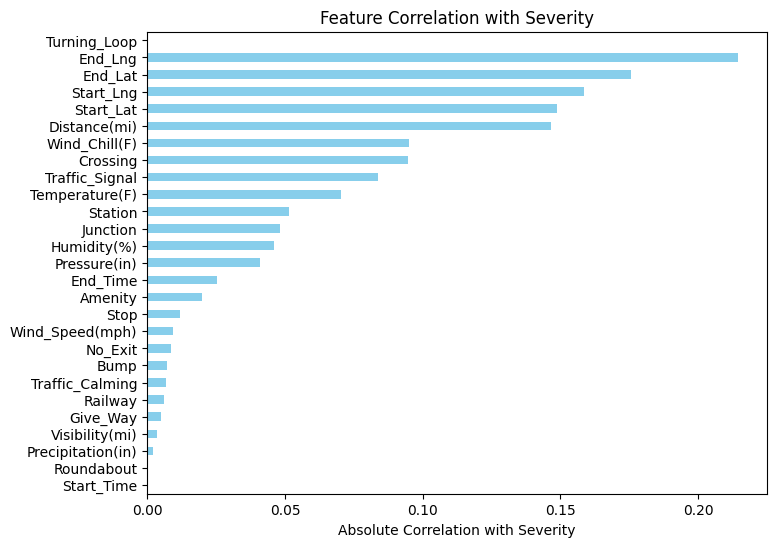

In [130]:
import pandas as pd
# 데이터 불러오기
df = pd.read_csv("balanced_data.csv")
# Severity와 연관 가능성이 있는 컬럼 리스트
related_columns = [
    "ID", "Source", "Severity", "Start_Time", "End_Time",
    "Start_Lat", "Start_Lng", "End_Lat", "End_Lng", "Distance(mi)",
    "Description", "Street", "City", "County", "State", "Zipcode",
    "Country", "Timezone", "Airport_Code", "Weather_Timestamp",
    "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)",
    "Visibility(mi)", "Wind_Direction", "Wind_Speed(mph)", "Precipitation(in)",
    "Weather_Condition", "Amenity", "Bump", "Crossing", "Give_Way", "Junction",
    "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming",
    "Traffic_Signal", "Turning_Loop", "Sunrise_Sunset", "Civil_Twilight",
    "Nautical_Twilight", "Astronomical_Twilight"
]
# 분석에 필요한 컬럼만 선택
df_selected = df[related_columns].copy()
# 시간 데이터를 수치형으로 변환 (예: 시(hour) 만 추출)
for time_col in ["Start_Time", "End_Time"]:
    df_selected[time_col] = pd.to_datetime(df_selected[time_col], errors='coerce').dt.hour
# 상관계수 계산 (수치형 변수만)
corr = df_selected.corr(numeric_only=True)
# Severity와 상관관계만 추출 & 절대값 순서 정렬
severity_corr = corr["Severity"].drop("Severity").sort_values(key=lambda x: abs(x), ascending=False)
print(":막대_차트: Severity와 각 변수의 상관계수:")
print(severity_corr)
# 시각화 (선택)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
severity_corr.abs().sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.xlabel("Absolute Correlation with Severity")
plt.title("Feature Correlation with Severity")
plt.show()

In [44]:
# 다른 클래스에 대해 다른 숫자를 지정하는 딕셔너리
label_encode = {"Severity": {2:0, 3:1, 4:2}}

# .replace를 사용하여 서로 다른 클래스를 숫자로 변경
df.replace(label_encode,inplace=True)

In [78]:
# 2. (추천) 위도 차이의 절댓값을 계산. 방향보다 차이의 크기가 중요할 때 유용합니다.
df['Lat_Difference_Abs'] = (df['Start_Lat'] - df['End_Lat'])

# 경도(Longitude)에 대해서도 동일하게 적용할 수 있습니다.
df['Lng_Difference_Abs'] = (df['Start_Lng'] - df['End_Lng'])

Severity
2    204710
0    204710
1    204710
Name: count, dtype: int64
Training a model...
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.575525	valid_0's multi_error: 0.241952
Predicting...
Accuracy: 0.7580


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

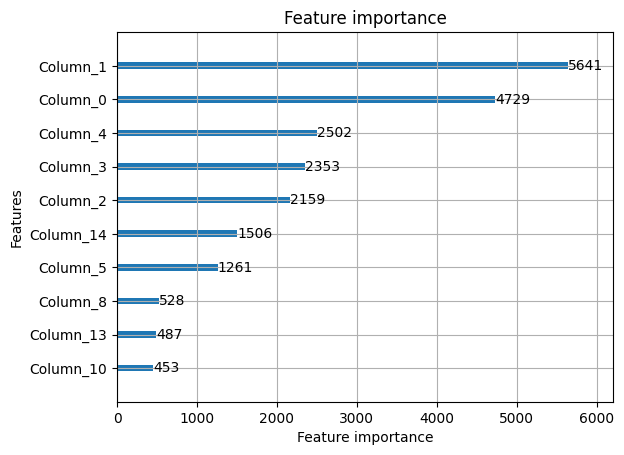

In [126]:
# 특성과 레이블 분리


features = [
    'Start_Lat', 'Start_Lng','End_Lng', 'End_Lat', 'Distance(mi)',
    'Wind_Chill(F)', 'Crossing', 'Traffic_Signal', 'Temperature(F)','Station'
    ,'Wind_Speed(mph)', 'Give_Way', 'Visibility(mi)', 'Humidity(%)', 'Pressure(in)'
    ,'Stop', 'Bump', 'Precipitation(in)', 'Traffic_Calming', 'Roundabout', 'Amenity', 'Junction'
]


# 사용하려는 특징 중에 결측값(NaN)이 있다면 채워주어야 합니다. (예: 0으로 채우기)
df[features] = df[features].fillna(0)
print(df['Severity'].value_counts())
X = df[features]
y = df['Severity']

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

lgb_train = lgb.Dataset(X_train, y_train)
# 검증용 데이터셋 (학습 중 성능 모니터링에 사용)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# 3. 파라미터 설정
params = {
    # --- 기본 설정 (유지 또는 수정) ---
    'objective': 'multiclass',
    'num_class': 3,
    # multi_logloss가 모델 학습에 더 좋은 지표입니다. 둘 다 볼 수도 있습니다.
    'metric': ['multi_logloss', 'multi_error'], 
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    
    # --- 모델 복잡도 및 성능 향상 (튜닝 대상) ---
    'num_leaves': 80,  # 기본값(31)보다 높여 모델의 표현력을 키움 (튜닝 필요)
    'max_depth': 15,   # 나무의 최대 깊이를 제한하여 과적합 방지

    # --- 과적합 방지를 위한 규제 (추가) ---
    'min_child_samples': 20, # 리프 노드의 최소 데이터 수
    'feature_fraction': 0.8, # 각 트리마다 사용할 특징의 비율을 조금 더 낮춤
    'bagging_fraction': 0.8, # 데이터 샘플링 비율 (과적합 방지)
    'bagging_freq': 1,       # bagging_fraction을 사용하려면 1 이상의 값 필요
    'lambda_l1': 0.1,        # L1 규제
    'lambda_l2': 0.1,        # L2 규제
}



print('Training a model...')
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=10)] # 조기 종료 콜백
)

print('Predicting...')
y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)

y_pred = np.argmax(y_pred_proba, axis=1)

gbm_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {gbm_accuracy:.4f}')

# --- 6. 피처 중요도 시각화 ---
# 이 부분은 기존 코드와 동일합니다.
lgb.plot_importance(model, max_num_features=10)

In [87]:
# 특성과 레이블 분리


features = [
    'Start_Lat', 'Start_Lng','End_Lng', 'End_Lat', 'Distance(mi)',
    'Wind_Chill(F)', 'Crossing', 'Traffic_Signal', 'Temperature(F)','Station'
    ,'Wind_Speed(mph)', 'Give_Way', 'Visibility(mi)', 'Humidity(%)', 'Pressure(in)'
    ,'Stop', 'Bump', 'Precipitation(in)', 'Traffic_Calming', 'Roundabout', 'Amenity', 'Junction'
]


# 사용하려는 특징 중에 결측값(NaN)이 있다면 채워주어야 합니다. (예: 0으로 채우기)
df[features] = df[features].fillna(0)

X = df[features]
y = df['Severity']

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

lgb_train = lgb.Dataset(X_train, y_train)
# 검증용 데이터셋 (학습 중 성능 모니터링에 사용)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# 3. 파라미터 설정
params = {
    # --- 기본 설정 (유지 또는 수정) ---
    'objective': 'multiclass',
    'num_class': 3,
    # multi_logloss가 모델 학습에 더 좋은 지표입니다. 둘 다 볼 수도 있습니다.
    'metric': ['multi_logloss', 'multi_error'], 
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    
    # --- 모델 복잡도 및 성능 향상 (튜닝 대상) ---
    'num_leaves': 80,  # 기본값(31)보다 높여 모델의 표현력을 키움 (튜닝 필요)
    'max_depth': 15,   # 나무의 최대 깊이를 제한하여 과적합 방지

    # --- 과적합 방지를 위한 규제 (추가) ---
    'min_child_samples': 20, # 리프 노드의 최소 데이터 수
    'feature_fraction': 0.8, # 각 트리마다 사용할 특징의 비율을 조금 더 낮춤
    'bagging_fraction': 0.8, # 데이터 샘플링 비율 (과적합 방지)
    'bagging_freq': 1,       # bagging_fraction을 사용하려면 1 이상의 값 필요
    'lambda_l1': 0.1,        # L1 규제
    'lambda_l2': 0.1,        # L2 규제
}


N_SPLITS = 6
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# 6. lgb.cv()를 사용하여 교차 검증 실행
print('Starting cross-validation...')
cv_results = lgb.cv(
    params,
    lgb_train,
    num_boost_round=1000,  # n_estimators를 충분히 크게 설정
    folds=skf,             # StratifiedKFold 객체를 전달
    stratified=True,       # 클래스 비율 유지 (lgb.cv의 자체 기능)
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)] # 조기 종료 콜백
)

print('Cross-validation finished.')

# 7. 교차 검증 결과 확인
# cv_results는 각 라운드별 성능을 담은 딕셔너리입니다.
# 마지막 라운드의 평균 에러율과 표준편차를 출력합니다.
final_round = len(cv_results['valid multi_error-mean']) -1 
mean_error = cv_results['valid multi_error-mean'][final_round]
std_error = cv_results['valid multi_error-stdv'][final_round]

# 평균 정확도로 변환하여 출력
mean_accuracy = 1 - mean_error
print(f"\n[Cross-Validation] Mean Accuracy: {mean_accuracy:.4f} (+/- {std_error:.4f})")


Starting cross-validation...


/opt/anaconda3/envs/jupyter/lib/python3.13/site-packages/sklearn/model_selection/_split.py:883: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid's multi_logloss: 0.523351 + 0.00173599	valid's multi_error: 0.215301 + 0.000592466
Cross-validation finished.

[Cross-Validation] Mean Accuracy: 0.7847 (+/- 0.0006)


In [94]:
optimal_rounds = final_round + 1 
print(f"Training a final model with {optimal_rounds} rounds...")

# 전체 데이터로 최종 모델 학습
final_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# 이 final_model을 사용하여 새로운 데이터에 대한 예측을 수행할 수 있습니다.
print("Final model training complete.")

Training a final model with 1000 rounds...
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.575525	valid_0's multi_error: 0.241952
Final model training complete.


Accuracy: 0.7580


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

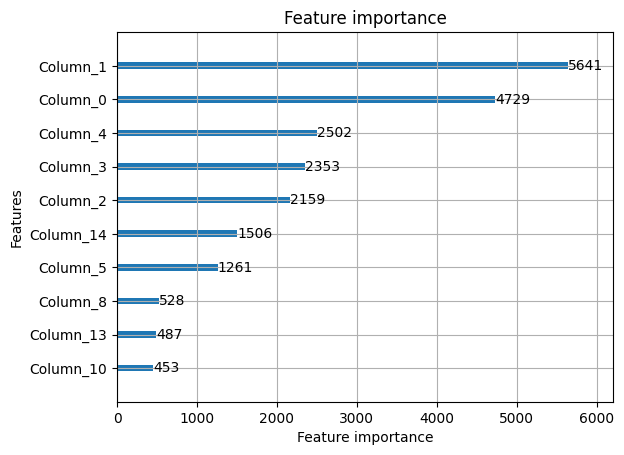

In [95]:
y_pred_proba = final_model.predict(X_test, num_iteration=model.best_iteration)

y_pred = np.argmax(y_pred_proba, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# --- 6. 피처 중요도 시각화 ---
# 이 부분은 기존 코드와 동일합니다.
lgb.plot_importance(model, max_num_features=10)

In [127]:
target_col = "Severity"
# Severity와의 상관계수 계산시 상위 10개 features
feature_cols = [
'Turning_Loop', 'End_Lng', 'End_Lat', 'Start_Lng', 'Start_Lat', 'Distance(mi)', 'Wind_Chill(F)', 'Crossing', 'Traffic_Signal', 'Temperature(F)']
df = df.dropna(subset=[target_col])  # 타겟 결측 제거
X = df[feature_cols].copy()
y = df[target_col].copy()
score = []
clf = RandomForestClassifier(n_estimators=10)  # RandomForest 사용
rf_scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
score.append(rf_scores.mean())
print('The accuration of classification is %.2f%%' % (rf_scores.mean() * 100))

The accuration of classification is 73.09%


In [128]:
target_col = "Severity"
feature_cols = [
  'Turning_Loop', 'End_Lng', 'End_Lat', 'Start_Lng', 'Start_Lat', 'Distance(mi)', 'Wind_Chill(F)',
  'Crossing', 'Traffic_Signal', 'Temperature(F)'
] #상관계수 상위 10개
'''
feature_cols = [
  'Start_Lat', 'Start_Lng','End_Lng', 'End_Lat', 'Distance(mi)',
    'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
    'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)',
    'Junction', 'Traffic_Signal', 'Stop', 'Crossing'
]
'''
df = df.dropna(subset=[target_col])  # 타깃 결측 제거
X = df[feature_cols].copy()
y = df[target_col].copy()
score = []
clf = DecisionTreeClassifier(
    criterion='gini',        # or 'entropy', 'log_loss'
    splitter='best',         # or 'random'
    max_depth=None,          # 트리 깊이 제한
    min_samples_split=2,     # 노드 분할 최소 샘플 수
    min_samples_leaf=1,      # 리프 노드 최소 샘플 수
    max_features=None,       # 분할 시 고려할 최대 피처 수
    class_weight=None,       # 클래스 불균형 시 가중치 부여
    random_state=42
)
dt_scores = cross_val_score(clf, X, y, cv=6, scoring="accuracy")
score.append(dt_scores.mean())
print('The accuration of classification is %.2f%%' % (dt_scores.mean() * 100))

The accuration of classification is 70.75%


그래프가 'model_accuracy_comparison.png' 파일로 저장되었습니다.


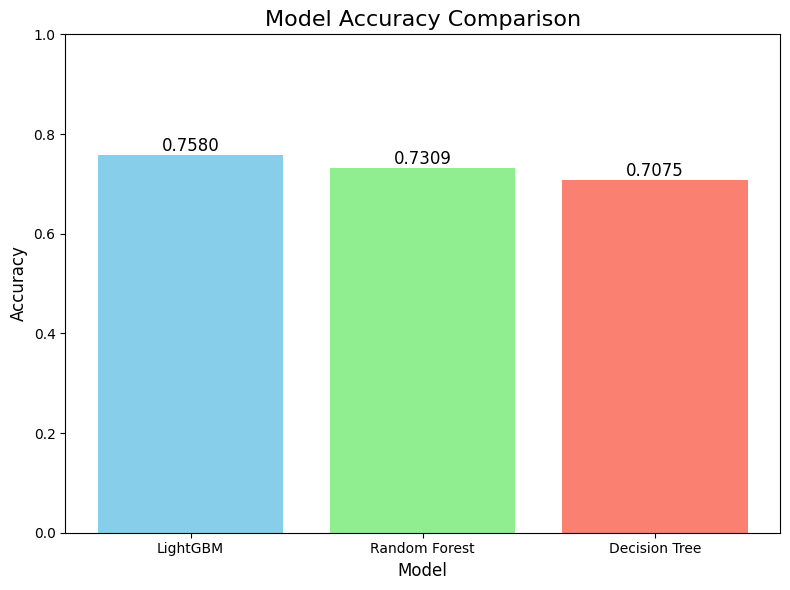

In [129]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# 1. 시각화할 데이터 준비
model_names = ['LightGBM', 'Random Forest', 'Decision Tree']
model_scores = [gbm_accuracy, rf_scores.mean(), dt_scores.mean()]

# 보기 좋게 데이터프레임으로 만들어 정렬
df_scores = pd.DataFrame({'Model': model_names, 'Accuracy': model_scores})
df_scores = df_scores.sort_values(by='Accuracy', ascending=False)


# 2. 막대그래프 시각화
plt.figure(figsize=(8, 6)) # 그래프 크기 설정
bars = plt.bar(df_scores['Model'], df_scores['Accuracy'], color=['skyblue', 'lightgreen', 'salmon'])

# 3. 그래프 꾸미기
plt.title('Model Accuracy Comparison', fontsize=16) # 그래프 제목
plt.xlabel('Model', fontsize=12) # x축 라벨
plt.ylabel('Accuracy', fontsize=12) # y축 라벨
plt.ylim(0, 1.0) # y축의 범위를 0에서 1.0으로 설정

# 각 막대 위에 정확도 수치 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12)


# 4. 그래프 저장 및 보여주기
plt.tight_layout() # 그래프 요소들이 겹치지 않게 조정
plt.savefig('model_accuracy_comparison.png') # 이미지 파일로 저장
# plt.show() # 주피터 노트북 등에서 그래프를 직접 보려면 이 코드의 주석을 해제하세요.

print("그래프가 'model_accuracy_comparison.png' 파일로 저장되었습니다.")